In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-25 19:48:16.590465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 19:48:16.604776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 19:48:16.605062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 19:48:16.606126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="denseRGB/denseRGB history "+current_time,dpi=300)

In [3]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.06)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.745, upper=1.25)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.06)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.85, upper=1.05)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [6]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  image=augment_inversion(image)
  image=augment_hue(image)
  image=augment_saturation(image)
  image=augment_brightness(image)
  image=augment_contrast(image)


  return image,label

In [7]:
ds_train_augmented = ds_train.map(augment_data)

In [8]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
#    elif epoch < 10:
#        return lr * tf.math.exp(-0.1)
    elif epoch < 100:
        return lr * tf.math.exp(-0.0075)
    elif epoch < 200:
        return lr * tf.math.exp(-0.005)
    else:
        return lr

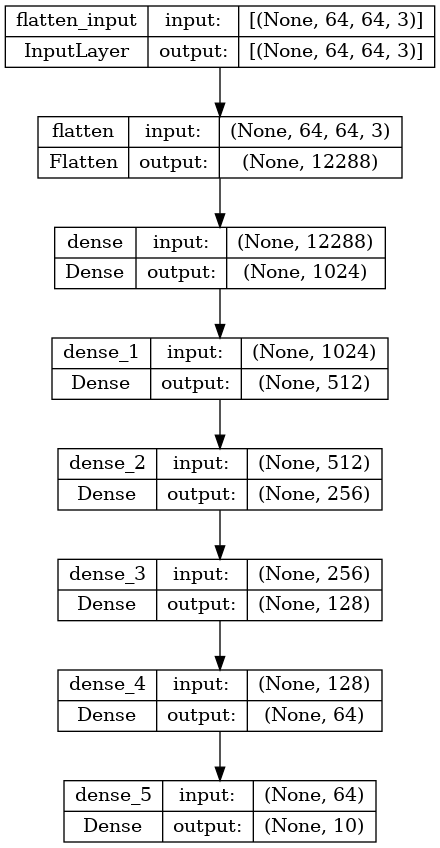

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [10]:
history = model.fit(
    ds_train_augmented,
    epochs=800,
    validation_data=ds_validation,
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        "denseRGB/denseRGB epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 1
    )
        #,tf.keras.callbacks.LearningRateScheduler(scheduler)
        ]
)

Epoch 1/800
169/169 [==============================] - 8s 36ms/step - loss: 2.3228 - sparse_categorical_accuracy: 0.1355 - val_loss: 2.3009 - val_sparse_categorical_accuracy: 0.1574
Epoch 2/800
169/169 [==============================] - 5s 32ms/step - loss: 2.3217 - sparse_categorical_accuracy: 0.1352 - val_loss: 2.2922 - val_sparse_categorical_accuracy: 0.1767
Epoch 3/800
169/169 [==============================] - 5s 32ms/step - loss: 2.3035 - sparse_categorical_accuracy: 0.1425 - val_loss: 2.2312 - val_sparse_categorical_accuracy: 0.1656
Epoch 4/800
169/169 [==============================] - 5s 30ms/step - loss: 2.2927 - sparse_categorical_accuracy: 0.1490 - val_loss: 2.2124 - val_sparse_categorical_accuracy: 0.1911
Epoch 5/800
169/169 [==============================] - 5s 31ms/step - loss: 2.2509 - sparse_categorical_accuracy: 0.1657 - val_loss: 2.1272 - val_sparse_categorical_accuracy: 0.1874
Epoch 6/800
169/169 [==============================] - 6s 33ms/step - loss: 2.2150 - spars

Epoch 46/800
169/169 [==============================] - 5s 31ms/step - loss: 2.0500 - sparse_categorical_accuracy: 0.2328 - val_loss: 2.0325 - val_sparse_categorical_accuracy: 0.2152
Epoch 47/800
169/169 [==============================] - 6s 33ms/step - loss: 2.0167 - sparse_categorical_accuracy: 0.2360 - val_loss: 1.9101 - val_sparse_categorical_accuracy: 0.2804
Epoch 48/800
169/169 [==============================] - 5s 32ms/step - loss: 2.0596 - sparse_categorical_accuracy: 0.2295 - val_loss: 1.9971 - val_sparse_categorical_accuracy: 0.2404
Epoch 49/800
169/169 [==============================] - 5s 31ms/step - loss: 2.0073 - sparse_categorical_accuracy: 0.2425 - val_loss: 2.0505 - val_sparse_categorical_accuracy: 0.2248
Epoch 50/800
169/169 [==============================] - 5s 32ms/step - loss: 1.9777 - sparse_categorical_accuracy: 0.2488 - val_loss: 1.8875 - val_sparse_categorical_accuracy: 0.3252
Epoch 51/800
169/169 [==============================] - 5s 32ms/step - loss: 2.1419 -

Epoch 91/800
169/169 [==============================] - 6s 33ms/step - loss: 1.9390 - sparse_categorical_accuracy: 0.2650 - val_loss: 1.9994 - val_sparse_categorical_accuracy: 0.2467
Epoch 92/800
169/169 [==============================] - 6s 33ms/step - loss: 1.9558 - sparse_categorical_accuracy: 0.2620 - val_loss: 1.7882 - val_sparse_categorical_accuracy: 0.2644
Epoch 93/800
169/169 [==============================] - 6s 34ms/step - loss: 1.8891 - sparse_categorical_accuracy: 0.2829 - val_loss: 1.7283 - val_sparse_categorical_accuracy: 0.3496
Epoch 94/800
169/169 [==============================] - 6s 33ms/step - loss: 1.9213 - sparse_categorical_accuracy: 0.2781 - val_loss: 1.7503 - val_sparse_categorical_accuracy: 0.3633
Epoch 95/800
169/169 [==============================] - 6s 33ms/step - loss: 1.8487 - sparse_categorical_accuracy: 0.2991 - val_loss: 1.7793 - val_sparse_categorical_accuracy: 0.3415
Epoch 96/800
169/169 [==============================] - 6s 33ms/step - loss: 1.8324 -

169/169 [==============================] - 5s 32ms/step - loss: 1.7230 - sparse_categorical_accuracy: 0.3659 - val_loss: 1.5226 - val_sparse_categorical_accuracy: 0.4511
Epoch 136/800
169/169 [==============================] - 5s 32ms/step - loss: 1.7096 - sparse_categorical_accuracy: 0.3599 - val_loss: 1.4522 - val_sparse_categorical_accuracy: 0.4959
Epoch 137/800
169/169 [==============================] - 6s 33ms/step - loss: 1.7166 - sparse_categorical_accuracy: 0.3597 - val_loss: 1.4634 - val_sparse_categorical_accuracy: 0.5126
Epoch 138/800
169/169 [==============================] - 5s 32ms/step - loss: 1.7462 - sparse_categorical_accuracy: 0.3503 - val_loss: 1.5853 - val_sparse_categorical_accuracy: 0.4556
Epoch 139/800
169/169 [==============================] - 6s 33ms/step - loss: 1.8575 - sparse_categorical_accuracy: 0.3055 - val_loss: 1.6582 - val_sparse_categorical_accuracy: 0.3948
Epoch 140/800
169/169 [==============================] - 5s 32ms/step - loss: 1.8854 - sparse_

169/169 [==============================] - 7s 42ms/step - loss: 1.6376 - sparse_categorical_accuracy: 0.3939 - val_loss: 1.3844 - val_sparse_categorical_accuracy: 0.5211
Epoch 180/800
169/169 [==============================] - 7s 41ms/step - loss: 1.6814 - sparse_categorical_accuracy: 0.3734 - val_loss: 1.4205 - val_sparse_categorical_accuracy: 0.4859
Epoch 181/800
169/169 [==============================] - 7s 42ms/step - loss: 1.6840 - sparse_categorical_accuracy: 0.3754 - val_loss: 1.4291 - val_sparse_categorical_accuracy: 0.4970
Epoch 182/800
169/169 [==============================] - 7s 41ms/step - loss: 1.6794 - sparse_categorical_accuracy: 0.3756 - val_loss: 1.3652 - val_sparse_categorical_accuracy: 0.4881
Epoch 183/800
169/169 [==============================] - 7s 41ms/step - loss: 1.6563 - sparse_categorical_accuracy: 0.3853 - val_loss: 1.4009 - val_sparse_categorical_accuracy: 0.4867
Epoch 184/800
169/169 [==============================] - 7s 43ms/step - loss: 1.6837 - sparse_

169/169 [==============================] - 7s 43ms/step - loss: 1.6949 - sparse_categorical_accuracy: 0.3740 - val_loss: 1.3995 - val_sparse_categorical_accuracy: 0.4559
Epoch 224/800
169/169 [==============================] - 7s 42ms/step - loss: 1.6288 - sparse_categorical_accuracy: 0.3979 - val_loss: 1.3666 - val_sparse_categorical_accuracy: 0.5263
Epoch 225/800
169/169 [==============================] - 7s 42ms/step - loss: 1.6560 - sparse_categorical_accuracy: 0.3828 - val_loss: 1.3166 - val_sparse_categorical_accuracy: 0.5381
Epoch 226/800
169/169 [==============================] - 7s 43ms/step - loss: 1.7018 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.5208 - val_sparse_categorical_accuracy: 0.4356
Epoch 227/800
169/169 [==============================] - 7s 42ms/step - loss: 1.6893 - sparse_categorical_accuracy: 0.3706 - val_loss: 1.3393 - val_sparse_categorical_accuracy: 0.5215
Epoch 228/800
169/169 [==============================] - 7s 42ms/step - loss: 1.6542 - sparse_

169/169 [==============================] - 7s 42ms/step - loss: 1.5915 - sparse_categorical_accuracy: 0.4050 - val_loss: 1.2628 - val_sparse_categorical_accuracy: 0.5452
Epoch 268/800
169/169 [==============================] - 7s 42ms/step - loss: 1.5544 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.2911 - val_sparse_categorical_accuracy: 0.5437
Epoch 269/800
169/169 [==============================] - 7s 43ms/step - loss: 1.5651 - sparse_categorical_accuracy: 0.4131 - val_loss: 1.2401 - val_sparse_categorical_accuracy: 0.5174
Epoch 270/800
169/169 [==============================] - 7s 44ms/step - loss: 1.5417 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.2275 - val_sparse_categorical_accuracy: 0.5463
Epoch 271/800
169/169 [==============================] - 7s 43ms/step - loss: 1.5469 - sparse_categorical_accuracy: 0.4218 - val_loss: 1.2800 - val_sparse_categorical_accuracy: 0.5407
Epoch 272/800
169/169 [==============================] - 8s 45ms/step - loss: 1.5868 - sparse_

169/169 [==============================] - 8s 47ms/step - loss: 1.5878 - sparse_categorical_accuracy: 0.4029 - val_loss: 1.2115 - val_sparse_categorical_accuracy: 0.5630
Epoch 312/800
169/169 [==============================] - 8s 46ms/step - loss: 1.5508 - sparse_categorical_accuracy: 0.4209 - val_loss: 1.3180 - val_sparse_categorical_accuracy: 0.5167
Epoch 313/800
169/169 [==============================] - 8s 46ms/step - loss: 1.4995 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.2213 - val_sparse_categorical_accuracy: 0.5596
Epoch 314/800
169/169 [==============================] - 8s 46ms/step - loss: 1.5152 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.2148 - val_sparse_categorical_accuracy: 0.5807
Epoch 315/800
169/169 [==============================] - 8s 46ms/step - loss: 1.4967 - sparse_categorical_accuracy: 0.4381 - val_loss: 1.2258 - val_sparse_categorical_accuracy: 0.5604
Epoch 316/800
169/169 [==============================] - 8s 46ms/step - loss: 1.5169 - sparse_

169/169 [==============================] - 7s 43ms/step - loss: 1.4770 - sparse_categorical_accuracy: 0.4444 - val_loss: 1.1515 - val_sparse_categorical_accuracy: 0.5748
Epoch 356/800
169/169 [==============================] - 7s 44ms/step - loss: 1.4348 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.1865 - val_sparse_categorical_accuracy: 0.5544
Epoch 357/800
169/169 [==============================] - 7s 44ms/step - loss: 1.4803 - sparse_categorical_accuracy: 0.4440 - val_loss: 1.1595 - val_sparse_categorical_accuracy: 0.5774
Epoch 358/800
169/169 [==============================] - 7s 44ms/step - loss: 1.5474 - sparse_categorical_accuracy: 0.4168 - val_loss: 1.1984 - val_sparse_categorical_accuracy: 0.5578
Epoch 359/800
169/169 [==============================] - 7s 44ms/step - loss: 1.5432 - sparse_categorical_accuracy: 0.4208 - val_loss: 1.2857 - val_sparse_categorical_accuracy: 0.5322
Epoch 360/800
169/169 [==============================] - 7s 44ms/step - loss: 1.4822 - sparse_

169/169 [==============================] - 7s 43ms/step - loss: 1.4631 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6011
Epoch 400/800
169/169 [==============================] - 7s 43ms/step - loss: 1.4478 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.2679 - val_sparse_categorical_accuracy: 0.5441
Epoch 401/800
169/169 [==============================] - 7s 44ms/step - loss: 1.5198 - sparse_categorical_accuracy: 0.4273 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.5381
Epoch 402/800
169/169 [==============================] - 7s 44ms/step - loss: 1.4707 - sparse_categorical_accuracy: 0.4472 - val_loss: 1.1330 - val_sparse_categorical_accuracy: 0.5841
Epoch 403/800
169/169 [==============================] - 7s 41ms/step - loss: 1.5330 - sparse_categorical_accuracy: 0.4243 - val_loss: 1.1413 - val_sparse_categorical_accuracy: 0.5770
Epoch 404/800
169/169 [==============================] - 7s 42ms/step - loss: 1.4395 - sparse_

169/169 [==============================] - 8s 47ms/step - loss: 1.5196 - sparse_categorical_accuracy: 0.4342 - val_loss: 1.1766 - val_sparse_categorical_accuracy: 0.5704
Epoch 444/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4444 - sparse_categorical_accuracy: 0.4617 - val_loss: 1.1832 - val_sparse_categorical_accuracy: 0.5604
Epoch 445/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4784 - sparse_categorical_accuracy: 0.4468 - val_loss: 1.1326 - val_sparse_categorical_accuracy: 0.5974
Epoch 446/800
169/169 [==============================] - 8s 46ms/step - loss: 1.5256 - sparse_categorical_accuracy: 0.4339 - val_loss: 1.1055 - val_sparse_categorical_accuracy: 0.6041
Epoch 447/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4462 - sparse_categorical_accuracy: 0.4599 - val_loss: 1.2053 - val_sparse_categorical_accuracy: 0.5674
Epoch 448/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4645 - sparse_

169/169 [==============================] - 8s 47ms/step - loss: 1.4815 - sparse_categorical_accuracy: 0.4476 - val_loss: 1.1678 - val_sparse_categorical_accuracy: 0.5819
Epoch 488/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4196 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.1861 - val_sparse_categorical_accuracy: 0.5656
Epoch 489/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4690 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.1408 - val_sparse_categorical_accuracy: 0.5678
Epoch 490/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4334 - sparse_categorical_accuracy: 0.4579 - val_loss: 1.1762 - val_sparse_categorical_accuracy: 0.5674
Epoch 491/800
169/169 [==============================] - 8s 48ms/step - loss: 1.4167 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.2347 - val_sparse_categorical_accuracy: 0.5519
Epoch 492/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4843 - sparse_

169/169 [==============================] - 8s 47ms/step - loss: 1.3642 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.1074 - val_sparse_categorical_accuracy: 0.5870
Epoch 532/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4050 - sparse_categorical_accuracy: 0.4737 - val_loss: 1.0943 - val_sparse_categorical_accuracy: 0.6015
Epoch 533/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4264 - sparse_categorical_accuracy: 0.4689 - val_loss: 1.0735 - val_sparse_categorical_accuracy: 0.6063
Epoch 534/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4510 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.1142 - val_sparse_categorical_accuracy: 0.6052
Epoch 535/800
169/169 [==============================] - 8s 48ms/step - loss: 1.3908 - sparse_categorical_accuracy: 0.4757 - val_loss: 1.1200 - val_sparse_categorical_accuracy: 0.5993
Epoch 536/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3426 - sparse_

169/169 [==============================] - 8s 47ms/step - loss: 1.4220 - sparse_categorical_accuracy: 0.4684 - val_loss: 1.1413 - val_sparse_categorical_accuracy: 0.5822
Epoch 576/800
169/169 [==============================] - 8s 48ms/step - loss: 1.3501 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.6207
Epoch 577/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3522 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.0724 - val_sparse_categorical_accuracy: 0.6233
Epoch 578/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3680 - sparse_categorical_accuracy: 0.4885 - val_loss: 1.0895 - val_sparse_categorical_accuracy: 0.6078
Epoch 579/800
169/169 [==============================] - 8s 47ms/step - loss: 1.4092 - sparse_categorical_accuracy: 0.4771 - val_loss: 1.1614 - val_sparse_categorical_accuracy: 0.5696
Epoch 580/800
169/169 [==============================] - 8s 48ms/step - loss: 1.3946 - sparse_

169/169 [==============================] - 8s 48ms/step - loss: 1.3047 - sparse_categorical_accuracy: 0.5158 - val_loss: 1.0866 - val_sparse_categorical_accuracy: 0.5870
Epoch 620/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3229 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.0791 - val_sparse_categorical_accuracy: 0.5981
Epoch 621/800
169/169 [==============================] - 8s 48ms/step - loss: 1.4202 - sparse_categorical_accuracy: 0.4703 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.5885
Epoch 622/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3757 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.1172 - val_sparse_categorical_accuracy: 0.5922
Epoch 623/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3927 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.1412 - val_sparse_categorical_accuracy: 0.5863
Epoch 624/800
169/169 [==============================] - 8s 48ms/step - loss: 1.2844 - sparse_

169/169 [==============================] - 8s 48ms/step - loss: 1.3925 - sparse_categorical_accuracy: 0.4825 - val_loss: 1.0592 - val_sparse_categorical_accuracy: 0.6185
Epoch 664/800
169/169 [==============================] - 8s 47ms/step - loss: 1.3328 - sparse_categorical_accuracy: 0.5017 - val_loss: 1.0787 - val_sparse_categorical_accuracy: 0.6089
Epoch 665/800
169/169 [==============================] - 8s 46ms/step - loss: 1.3632 - sparse_categorical_accuracy: 0.4878 - val_loss: 1.0708 - val_sparse_categorical_accuracy: 0.6089
Epoch 666/800
169/169 [==============================] - 8s 46ms/step - loss: 1.3376 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.6022
Epoch 667/800
169/169 [==============================] - 7s 43ms/step - loss: 1.3098 - sparse_categorical_accuracy: 0.5125 - val_loss: 1.0747 - val_sparse_categorical_accuracy: 0.6167
Epoch 668/800
169/169 [==============================] - 7s 41ms/step - loss: 1.2919 - sparse_

169/169 [==============================] - 7s 44ms/step - loss: 1.4307 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.1089 - val_sparse_categorical_accuracy: 0.5978
Epoch 708/800
169/169 [==============================] - 7s 43ms/step - loss: 1.3163 - sparse_categorical_accuracy: 0.5032 - val_loss: 1.0536 - val_sparse_categorical_accuracy: 0.6163
Epoch 709/800
169/169 [==============================] - 7s 42ms/step - loss: 1.3050 - sparse_categorical_accuracy: 0.5134 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.5248
Epoch 710/800
169/169 [==============================] - 7s 42ms/step - loss: 1.2808 - sparse_categorical_accuracy: 0.5192 - val_loss: 1.1562 - val_sparse_categorical_accuracy: 0.5856
Epoch 711/800
169/169 [==============================] - 7s 43ms/step - loss: 1.2919 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.1491 - val_sparse_categorical_accuracy: 0.5667
Epoch 712/800
169/169 [==============================] - 7s 43ms/step - loss: 1.2946 - sparse_

169/169 [==============================] - 7s 43ms/step - loss: 1.3292 - sparse_categorical_accuracy: 0.5067 - val_loss: 1.0390 - val_sparse_categorical_accuracy: 0.6256
Epoch 752/800
169/169 [==============================] - 7s 44ms/step - loss: 1.2271 - sparse_categorical_accuracy: 0.5402 - val_loss: 1.0287 - val_sparse_categorical_accuracy: 0.6159
Epoch 753/800
169/169 [==============================] - 7s 42ms/step - loss: 1.2322 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.5741
Epoch 754/800
169/169 [==============================] - 7s 42ms/step - loss: 1.3000 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.0716 - val_sparse_categorical_accuracy: 0.6181
Epoch 755/800
169/169 [==============================] - 7s 43ms/step - loss: 1.3213 - sparse_categorical_accuracy: 0.5055 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.6063
Epoch 756/800
169/169 [==============================] - 7s 43ms/step - loss: 1.3118 - sparse_

169/169 [==============================] - 7s 42ms/step - loss: 1.3402 - sparse_categorical_accuracy: 0.4981 - val_loss: 1.0825 - val_sparse_categorical_accuracy: 0.6148
Epoch 796/800
169/169 [==============================] - 7s 42ms/step - loss: 1.2776 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.1320 - val_sparse_categorical_accuracy: 0.5922
Epoch 797/800
169/169 [==============================] - 7s 43ms/step - loss: 1.3030 - sparse_categorical_accuracy: 0.5190 - val_loss: 1.2550 - val_sparse_categorical_accuracy: 0.5359
Epoch 798/800
169/169 [==============================] - 7s 43ms/step - loss: 1.2343 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.0703 - val_sparse_categorical_accuracy: 0.6122
Epoch 799/800
169/169 [==============================] - 7s 42ms/step - loss: 1.4035 - sparse_categorical_accuracy: 0.4823 - val_loss: 1.1211 - val_sparse_categorical_accuracy: 0.5959
Epoch 800/800
169/169 [==============================] - 7s 41ms/step - loss: 1.2739 - sparse_


Test accuracy: 0.6303703784942627


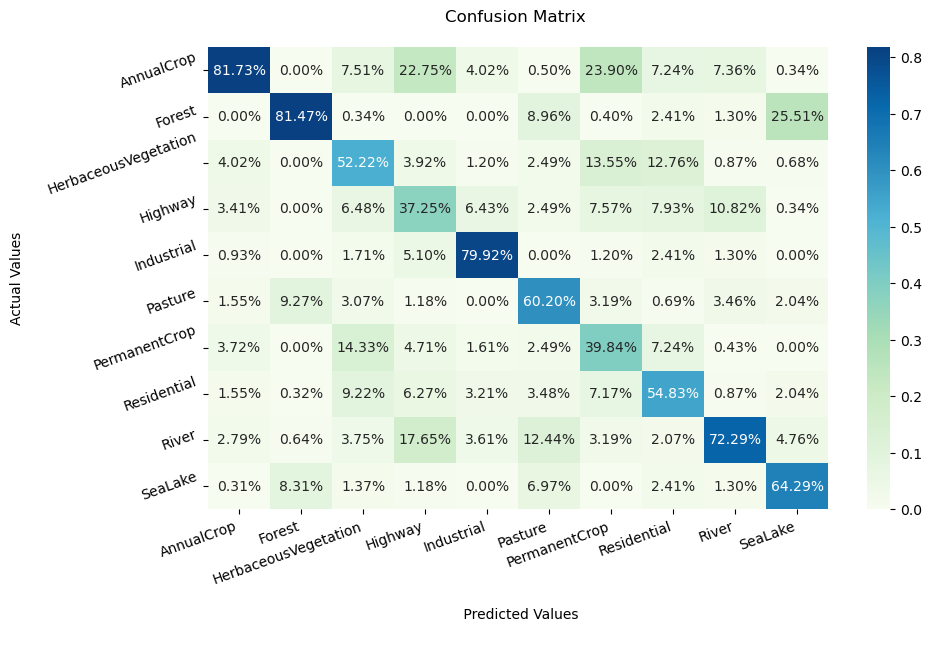

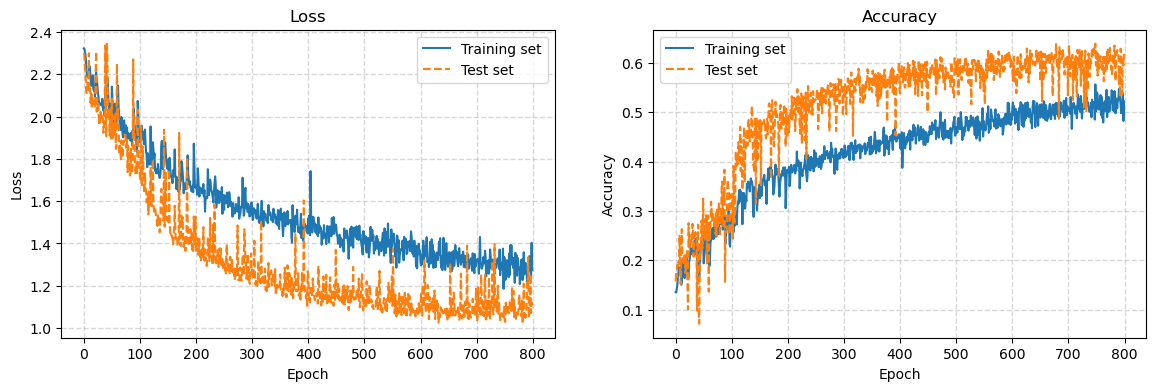

In [11]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="denseRGB/denseRGB confusion matrix "+current_time,dpi=300)
render_training_history(history)
